In [1]:

import matplotlib.pyplot as plt
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import numpy as np
import time as tm
import scanpy as sc
import anndata
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

import torch
from dataset import setup_seed,train_test_valid_loader_setup,get_accuracy #
from model import tre
from train import run_inference_for_epoch,get_evaluate_loss,lossplot
torch.set_default_tensor_type(torch.FloatTensor)
import pyro
from pyro.infer import SVI,  JitTraceEnum_ELBO, Trace_ELBO, config_enumerate
from pyro.optim import Adam, ExponentialLR
from sklearn.metrics import accuracy_score, f1_score
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [2]:
input_path = "/home/yingwang/cl/benchmark/trevi/data1"
output_path = "/home/yingwang/cl/benchmark/trevi/output1"

In [3]:
torch.cuda.is_available()
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 2080 Ti'

In [4]:
#Set the missing initial value
setup_seed(233)
learning_rate =3e-4#1e-3
decay_rate = 0.97
enum_discrete = "parallel"
beta_1 = 0.99
cuda = True
float64 = False
config_enum = "parallel"
validation_fold = 0.1
batch_size = 30
test_size=0.3
unsuptrain_size=0.3
valid_size=0.1
sup_num, unsup_num = 0, 0

In [5]:
#Set the input path
datafile = pd.read_csv("{}/{}".format(input_path,"rnacount_a549.csv"),index_col=0)
label_file=pd.read_csv("{}/{}".format(input_path,"label_a549.csv"),index_col=0)
acc_p = pd.read_csv("{}/{}".format(input_path,"accp_a549.csv"),index_col=0)
mask = pd.read_csv("{}/{}".format(input_path,"tf_gene.csv"),index_col=0)
tfname = pd.read_csv("{}/{}".format(input_path,"tf_gene.csv"),index_col=0)

In [6]:
#Input data preprocess
classnum=len(np.unique(label_file))
savebarcode=pd.DataFrame(datafile.index)
barcode=savebarcode.index.tolist()
acc_p=acc_p.fillna(0)
datafile=datafile.fillna(0)
label_file=label_file.values
datafile=datafile.values
acc_p=acc_p.values
acc_p=acc_p+0.01
acc_p=acc_p.astype(np.float32)
datafile=datafile.astype(np.float32)
mask=mask.values

In [7]:
acc_p.shape

(3260, 3000)

In [8]:
mask.shape

(3000, 34)

In [9]:
#Setup dataloader

data_loaders = {'sup':None, 'unsup':None, 'valid':None ,'test':None}
data_loaders['sup'],data_loaders['valid'],data_loaders['unsup'],data_loaders['test'] = train_test_valid_loader_setup(datafile,label_file,acc_p,barcode,classnum,cuda,float64,batch_size,test_size, unsuptrain_size,valid_size)

In [10]:
#Setup model
z_dim=mask.shape[1]
output_size_rna = len(np.unique(label_file))
input_size_rna = datafile.shape[1]
mask_size = mask.shape[0]*mask.shape[1]
aux_loss=True

scc = tre(
    output_size = output_size_rna,
    input_size = input_size_rna,
    z_dim = z_dim,
    hidden_layers = [30],
    use_cuda = cuda,
    config_enum = enum_discrete,
    mask = mask,
    mask_size =mask_size,
    aux_loss_multiplier = 46,
    )
    
# setup the optimizer
adam_params = {'lr': learning_rate, 'betas':(beta_1, 0.999), 'weight_decay': 0.001}#0.001
#optimizer = Adam(adam_params)
optimizer = torch.optim.Adam
decayRate = decay_rate
scheduler = ExponentialLR({'optimizer': optimizer, 'optim_args': adam_params, 'gamma': decayRate})

pyro.clear_param_store()
# set up the loss(es) for inference, wrapping the guide in config_enumerate builds the loss as a sum
# by enumerating each class label form the sampled discrete categorical distribution in the model
guide = config_enumerate(scc.guide, enum_discrete, expand = True)
Elbo = JitTraceEnum_ELBO 
elbo = Elbo(max_plate_nesting = 1, strict_enumeration_warning = False)
loss_basic = SVI(scc.model, guide, scheduler, loss = elbo)


In [11]:
# build a list of all losses considered
losses = [loss_basic]
if aux_loss:
            elbo =  Trace_ELBO()
            loss_aux = SVI(scc.model_classify, scc.guide_classify, scheduler, loss = elbo)
            losses.append(loss_aux)
            loss_aux1 = SVI(scc.model_classify1, scc.guide_classify1, scheduler, loss = elbo)
            losses.append(loss_aux1)
    
num_epochs =50
decay_epochs =20
sup_num = data_loaders['sup'].dataset.data.shape[0]#细胞数
unsup_num = data_loaders['unsup'].dataset.data.shape[0]
valid_num=data_loaders['valid'].dataset.data.shape[0]
test_num=data_loaders['test'].dataset.data.shape[0]


3260

In [12]:
print(sup_num,unsup_num,valid_num,test_num)

1437 685 160 978


In [13]:

try:
        # seen across epochs over the supervised training set
        # and the corresponding testing set and the state of the networks
        best_valid_acc = 0.0
        best_valid_f1m = 0.0

        asso_valid_f1m = 0.0
        asso_valid_f1w = 0.0
        asso_valid_pre = 0.0
        asso_valid_rec = 0.0
        asso_valid_mcc = 0.0
        
        asso_unsup_acc = 0.0
        asso_unsup_f1m = 0.0
        asso_unsup_f1w = 0.0
        asso_unsup_pre = 0.0
        asso_unsup_rec = 0.0
        asso_unsup_mcc = 0.0
        
        tr_start=tm.time()
        unsupplosses=[]
        supplosses=[]
        vallosses=[]
        # run inference for a certain number of epochs
        for i in range(0, num_epochs):
            ep_tr_start = tm.time()

            # get the losses for an epoch
            
            epoch_losses_sup, epoch_losses_unsup = run_inference_for_epoch(
                data_loaders['sup'], data_loaders['unsup'], losses, cuda
            )
            epoch_losses_valid = get_evaluate_loss(
               data_loaders['valid'], losses, cuda
            ) 
            # compute average epoch losses i.e. losses per example
            avg_epoch_losses_sup = map(lambda v: v / sup_num, epoch_losses_sup)
            avg_epoch_losses_unsup = map(lambda v: v / unsup_num, epoch_losses_unsup) if unsup_num > 0 else [0] * len(epoch_losses_unsup)
            
            avg_epoch_losses_sup = map(lambda v: "{:.4f}".format(v), avg_epoch_losses_sup)
            avg_epoch_losses_unsup = map(lambda v: "{:.4f}".format(v), avg_epoch_losses_unsup)

            
            avg_epoch_losses_valid = map(lambda v: v /valid_num, epoch_losses_valid) if valid_num > 0 else [0] * len(epoch_losses_valid)
            avg_epoch_losses_valid = map(lambda v: "{:.4f}".format(v), avg_epoch_losses_valid)   
            # store the loss
            str_loss_sup = " ".join(map(str, avg_epoch_losses_sup))
            supplosses.append(str_loss_sup)

            str_loss_unsup = " ".join(map(str, avg_epoch_losses_unsup))
            unsupplosses.append(str_loss_unsup)
            
            str_loss_valid = " ".join(map(str, avg_epoch_losses_valid))
            vallosses.append(str_loss_valid) 
            str_print = "{} epoch: avg losses {}".format(
                i+1, "{} {} {}".format(str_loss_sup, str_loss_unsup,str_loss_valid)
            )

            validation_accuracy, validation_f1_macro, validation_f1_weighted, validation_precision, validation_recall, validation_mcc,ARI, NMI = get_accuracy(
                data_loaders["valid"], scc.classifier
            )

            str_print += " validation accuracy {:.4f}".format(validation_accuracy)
            str_print += " F1 {:.4f}(macro) {:.4f}(weighted)".format(validation_f1_macro, validation_f1_weighted)
            str_print += " precision {:.4f} recall {:.4f}".format(validation_precision, validation_recall)
            str_print += " mcc {:.4f}".format(validation_mcc)
            str_print += " ARI {:.4f} NMI {:.4f}".format(ARI, NMI)  

            
            unsup_accuracy, unsup_f1_macro, unsup_f1_weighted, unsup_precision, unsup_recall, unsup_mcc,ARI, NMI = get_accuracy(
                    data_loaders['unsup'], scc.classifier)
                           
            
            ep_tr_time = tm.time() - ep_tr_start
            str_print += " elapsed {:.4f} seconds".format(ep_tr_time)
            print(str_print)
            # update the best validation accuracy and the state of the parent 
            # module (including the networks)
            if best_valid_acc <= validation_accuracy:
                do_update = False
                if best_valid_acc < validation_accuracy:
                    do_update = True
                elif best_valid_f1m < validation_f1_macro:
                    do_update = True

                if do_update:
                    best_valid_acc = validation_accuracy
                    best_valid_f1m = validation_f1_macro
                    
                    asso_valid_f1m = validation_f1_macro
                    asso_valid_f1w = validation_f1_weighted
                    asso_valid_pre = validation_precision
                    asso_valid_rec = validation_recall
                    asso_valid_mcc = validation_mcc

                    
                    asso_unsup_acc = unsup_accuracy
                    asso_unsup_f1m = unsup_f1_macro
                    asso_unsup_f1w = unsup_f1_weighted
                    asso_unsup_pre = unsup_precision
                    asso_unsup_rec = unsup_recall
                    asso_unsup_mcc = unsup_mcc

            if i%decay_epochs == 0:
                scheduler.step() 


        tr_time=tm.time()-tr_start
        print('running time: {} secs'.format(tr_time))

        print(
            "best validation accuracy {:.4f}".format(
                best_valid_acc
            ),
        )
        print(
                "unsup accuracy: {:.4f} \nF1: {:.4f}(macro) {:.4f}(weighted) \nprecision {:.4f} recall {:.4f} \nmcc {:.4f}".format(
                    asso_unsup_acc, asso_unsup_f1m, asso_unsup_f1w, asso_unsup_pre, asso_unsup_rec, asso_unsup_mcc
                ),
            )

finally:print("train done") 


1 epoch: avg losses 10011.1211 2421.7600 9633.8869 3856.3124 2313.6227 2515.0989 3580.0536 2331.3592 2419.5154 validation accuracy 0.4133 F1 0.1950(macro) 0.2418(weighted) precision 0.1378 recall 0.3333 mcc 0.0000 ARI 0.0000 NMI 0.0000 elapsed 17.7260 seconds
2 epoch: avg losses 3350.8251 2388.9551 2498.9083 2820.8600 2281.7426 2440.8884 2543.6283 2259.4036 2365.2507 validation accuracy 0.3933 F1 0.1882(macro) 0.2258(weighted) precision 0.1320 recall 0.3278 mcc -0.0706 ARI -0.0020 NMI 0.0111 elapsed 5.4220 seconds
3 epoch: avg losses 2110.0397 2306.6086 2456.7177 1259.9582 2102.7239 2389.6778 1020.4318 2046.6878 2340.9753 validation accuracy 0.4200 F1 0.2601(macro) 0.3041(weighted) precision 0.6225 recall 0.3469 mcc 0.0368 ARI -0.0046 NMI 0.0213 elapsed 5.8024 seconds
4 epoch: avg losses 665.1563 1995.6254 2438.4954 462.8360 1692.5882 2361.5642 397.2006 1802.4030 2297.1845 validation accuracy 0.6000 F1 0.5723(macro) 0.5741(weighted) precision 0.6762 recall 0.5654 mcc 0.3806 ARI 0.2316 

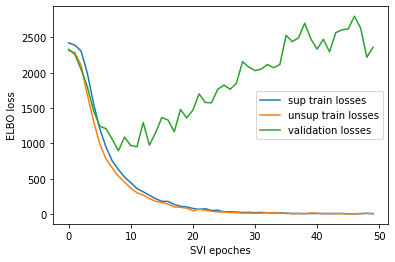

In [14]:
torch.save(scc.state_dict(), "%s/trevi9.14.pkl" % output_path)
output_size_rna = len(np.unique(label_file))
input_size_rna = datafile.shape[1]


In [15]:

scc = tre(
    output_size = output_size_rna,
    input_size = input_size_rna,
    z_dim = z_dim,
    hidden_layers = [30],
    use_cuda = cuda,
    config_enum = enum_discrete,
    mask = mask,
    mask_size =mask_size,
    aux_loss_multiplier = 46,
    )
scc.load_state_dict(torch.load("%s/trevi9.14.pkl" % output_path))
# predict
predictions, scores, actuals, zs, tf ,theta ,xss,barcodes= [], [], [], [], [],[],[],[]

# use the appropriate data loader
for (xs, ys,acc_p,barcode) in data_loaders['test']:
        # use classification function to compute all predictions for each batch
        yhats, yscores = scc.classifier_with_probability(xs)
        scores.append(yscores)

        _, yhats = torch.topk(yhats, 1)
        predictions.append(yhats.cpu().detach().numpy())

        _, ys = torch.topk(ys, 1)
        actuals.append(ys.cpu().detach().numpy())

        z=scc.latent_embedding(xs)
        zs.append(z.cpu().detach().numpy())

        tfs=abs(scc.predicted_tf(xs))
        tf.append(tfs.cpu().detach().numpy())

        xss.append(xs.cpu().detach().numpy())
        barcodes.append(barcode.cpu().detach().numpy())


predictions = np.concatenate(predictions, 0)
scores = torch.cat(scores, dim=0).cpu().detach().numpy()
actuals = np.concatenate(actuals, 0)
zs = np.concatenate(zs, 0)
tf = np.concatenate(tf, 0)
xss= np.concatenate(xss, 0)
barcodes= np.concatenate(barcodes, 0)

temp=np.array(torch.tensor(actuals.reshape(-1,1))).astype(str)
dict={'0':'CD14 Mono', '1': 'CD16 Mono', '2': 'CD4 Naive', '3': 'CD4 TCM', '4': 'CD4 TEM', '5':'CD8 Naive', '6':'CD8 TEM_1', '7': 'CD8 TEM_2', '8':'HSPC', '9': 'Intermediate B', '10': 'MAIT', '11': 'Memory B', '12':'NK', '13': 'Naive B', '14': 'Plasma','15': 'Treg', '16': 'cDC', '17': 'gdT', '18':'pDC'}
temp1= np.vectorize(dict.get)(temp)
temppre=np.array(torch.tensor(predictions.reshape(-1,1))).astype(str)
dict={'0':'CD14 Mono', '1': 'CD16 Mono', '2': 'CD4 Naive', '3': 'CD4 TCM', '4': 'CD4 TEM', '5':'CD8 Naive', '6':'CD8 TEM_1', '7': 'CD8 TEM_2', '8':'HSPC', '9': 'Intermediate B', '10': 'MAIT', '11': 'Memory B', '12':'NK', '13': 'Naive B', '14': 'Plasma','15': 'Treg', '16': 'cDC', '17': 'gdT', '18':'pDC'}
temppre1= np.vectorize(dict.get)(temppre)

test_accuracy, test_f1_macro, test_f1_weighted, test_precision, test_recall, test_mcc,ARI, NMI = get_accuracy(
                    data_loaders["test"], scc.classifier
                )
str_print1 = " test accuracy {:.4f}".format(test_accuracy)
str_print1 += " F1 {:.4f}(macro) {:.4f}(weighted)".format(test_f1_macro, test_f1_weighted)
str_print1 += " precision {:.4f} recall {:.4f}".format(test_precision, test_recall)
str_print1 += " mcc {:.4f}".format(test_mcc)            
str_print1 += " ARI {:.4f} NMI {:.4f}".format(ARI, NMI)  
print("accuracy:{:.4f}, f1_macro:{:.4f}, f1_weighted:{:.4f},ARI:{:.4f}, NMI:{:.4f}".format(test_accuracy,test_f1_macro,test_f1_weighted ,ARI,NMI))


accuracy:0.7729, f1_macro:0.7768, f1_weighted:0.7734,ARI:0.4268, NMI:0.3829


... storing 'cell_type' as categorical


         Falling back to preprocessing with `sc.pp.pca` and default params.


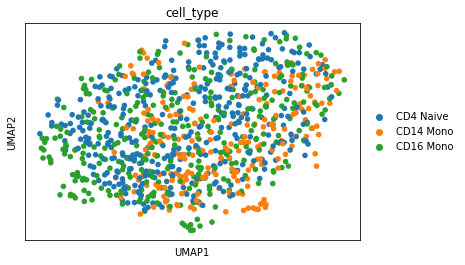

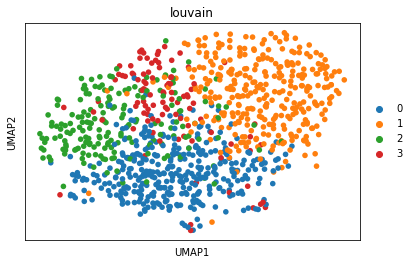

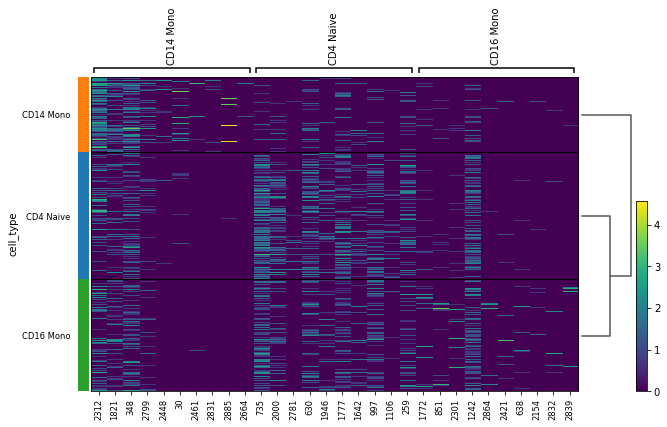

In [16]:

# visulization
prior_adata = anndata.AnnData(X=xss)
prior_adata.obsm["X_multi_vi"] = xss
sc.pp.neighbors(prior_adata, use_rep="X_multi_vi", n_neighbors=30)
sc.tl.umap(prior_adata, min_dist=0.3)

sc.tl.louvain(prior_adata)
originalcell=prior_adata.obs['louvain']
prior_adata.obs['cell_type'] = temp1
# origin cell label
sc.pl.umap(prior_adata, color=['cell_type'], show=False)
plt.savefig("%s/xs_actual_label.pdf" % output_path, format="pdf")
# origin cell label
sc.pl.umap(prior_adata, color=['louvain'], show=False)
plt.savefig("%s/xs_predict_labl.pdf" % output_path, format="pdf")
        
sc.tl.rank_genes_groups(prior_adata, 'cell_type', method="t-test")
sc.pl.rank_genes_groups_heatmap(prior_adata, n_genes=10, groupby='cell_type', show=False)
plt.savefig("%s/xs_heatmap.pdf" % output_path, format="pdf")
groundtruth=prior_adata.obs['cell_type']


In [17]:

from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics import adjusted_rand_score

In [18]:
ARI1 = adjusted_rand_score(groundtruth.ravel(), originalcell.ravel())
NMI1 = normalized_mutual_info_score(groundtruth.ravel(), originalcell.ravel())

accuracy1 = accuracy_score(groundtruth.ravel(), originalcell.ravel())
f1_macro1 = f1_score(groundtruth.ravel(), originalcell.ravel(), average='macro')
f1_weighted1 = f1_score(groundtruth.ravel(), originalcell.ravel(), average='weighted')
print("xs accuracy:{:.4f}, f1_macro:{:.4f}, f1_weighted:{:.4f},ARI:{:.4f}, NMI:{:.4f}".format(accuracy1,f1_macro1  ,f1_weighted1 ,ARI1,NMI1))
   


xs accuracy:0.0000, f1_macro:0.0000, f1_weighted:0.0000,ARI:0.0198, NMI:0.0473


... storing 'cell_type' as categorical
... storing 'cell_type pre' as categorical


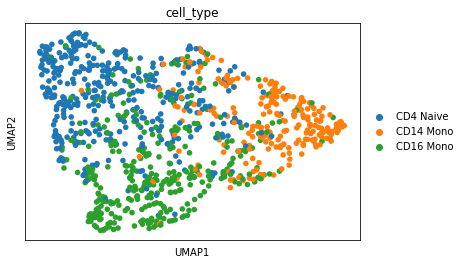

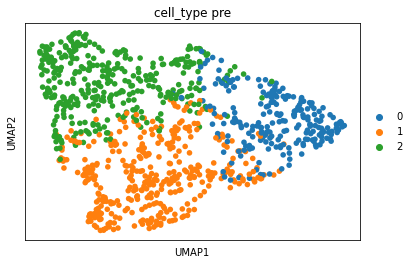

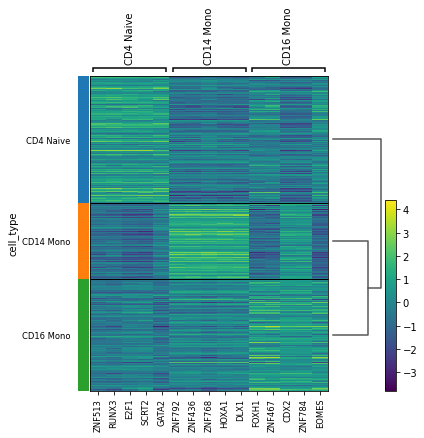

In [19]:
genename=pd.DataFrame(tfname.index)
tfname1=pd.DataFrame(tfname.columns)
prior_adata1 = anndata.AnnData(X=zs,var=tfname1)
prior_adata1.obsm["X_multi_vi"] = zs
sc.pp.neighbors(prior_adata1, use_rep="X_multi_vi", n_neighbors=20)
sc.tl.umap(prior_adata1, min_dist=0.3)

sc.tl.louvain(prior_adata1)
prior_adata1.obs['cell_type'] = temp1
# origin cell label
sc.pl.umap(prior_adata1, color=['cell_type'], show=False)

plt.savefig("%s/ztf_actual_labl.pdf" % output_path, format="pdf")
# plt.show()
prior_adata1.obs['cell_type pre'] = temppre
# origin cell label
sc.pl.umap(prior_adata1, color=['cell_type pre'], show=False)
plt.savefig("%s/ztf_predict_labl.pdf" % output_path, format="pdf")
prior_adata1.var.index=prior_adata1.var[0]
sc.tl.rank_genes_groups(prior_adata1, 'cell_type', method="t-test")
sc.pl.rank_genes_groups_heatmap(prior_adata1, n_genes=5, groupby='cell_type', show=False)
plt.savefig("%s/ztf_heatmap.pdf" % output_path, format="pdf")


In [20]:
ztf=pd.DataFrame(zs)
ztf.index=barcodes
ztf.columns=tfname1
ztf.to_csv("%s/ztf_embedding.csv" % output_path)


... storing 'cell_type' as categorical


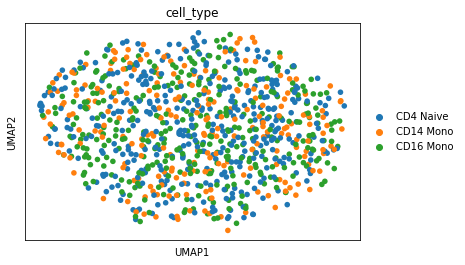

In [21]:
prior_adata2 = anndata.AnnData(X=tf)
prior_adata2.obsm["X_multi_vi"] = tf
#cell_embeddings = pd.read_csv(input_path+'snare_p0_wnn_output.txt', sep="\t",index_col=0).iloc[:,[5,12]]
#prior_adata.obs['cell_type'] = cell_embeddings.loc[dataset.barcodes,"IdentChar"].to_list()
sc.pp.neighbors(prior_adata2, use_rep="X_multi_vi", n_neighbors=10)
sc.tl.umap(prior_adata2, min_dist=0.3)

sc.tl.louvain(prior_adata2)
prior_adata2.obs['cell_type'] = temp1#np.array(torch.tensor(actuals.reshape(-1,1))).astype(str)#actuals和test——label——file中不一样
# origin cell label
sc.pl.umap(prior_adata2, color=['cell_type'])

In [22]:
10200/3000

3.4

In [23]:
zs.shape

(960, 34)

In [24]:
tfname = pd.read_csv("{}/{}".format(input_path,"tf_gene.csv"),index_col=0)
tfm=pd.DataFrame(tf)
tfm.index=barcodes
tfm['y']=actuals

        


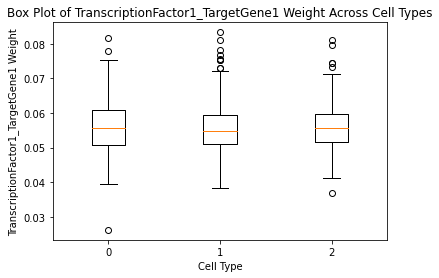

In [25]:
import matplotlib.pyplot as plt

# 假设你的数据框 tfm 包含以下列： 'y', 'TranscriptionFactor1_TargetGene1'
# 'TranscriptionFactor1_TargetGene1' 列包含了第一个转录因子对第一个靶基因的调控权重

# 分组数据框，按照 'y' 列的值进行分组
grouped = tfm.groupby('y')


# 提取第一个转录因子对第一个靶基因的
data_to_plot = [group[0].values for name, group in grouped]

# 绘制箱线图
plt.boxplot(data_to_plot, labels=grouped.groups.keys())
plt.xlabel('Cell Type')
plt.ylabel('TranscriptionFactor1_TargetGene1 Weight')
plt.title('Box Plot of TranscriptionFactor1_TargetGene1 Weight Across Cell Types')
plt.show()


In [26]:
tfname#前3000是E2F2的 取 靶基因位置就好了

,ZBTB17,ZNF436,RUNX3,JUN,ZNF513,DLX1,EOMES,GATA2,IRX2,HOXA1,...,JUND,MEF2B,ZNF792,HNRNPL,DBP,ZNF579,ZNF784,SCRT2,E2F1,NR3C1
RP11-34P13.7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
RP11-34P13.15,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
RP11-54O7.3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
C1ORF170,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
HES4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GM20896,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SNOU109,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SNORA2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
U3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
tfname[0]=range(3000)
tfname[tfname.index=='ANXA4']

,ZBTB17,ZNF436,RUNX3,JUN,ZNF513,DLX1,EOMES,GATA2,IRX2,HOXA1,...,MEF2B,ZNF792,HNRNPL,DBP,ZNF579,ZNF784,SCRT2,E2F1,NR3C1,0


In [28]:
tfname[tfname.index=='SPI1']

,ZBTB17,ZNF436,RUNX3,JUN,ZNF513,DLX1,EOMES,GATA2,IRX2,HOXA1,...,MEF2B,ZNF792,HNRNPL,DBP,ZNF579,ZNF784,SCRT2,E2F1,NR3C1,0


In [29]:
tfname[tfname.index=='SPATA7']

,ZBTB17,ZNF436,RUNX3,JUN,ZNF513,DLX1,EOMES,GATA2,IRX2,HOXA1,...,MEF2B,ZNF792,HNRNPL,DBP,ZNF579,ZNF784,SCRT2,E2F1,NR3C1,0


In [30]:
98*3000

294000

In [31]:
tfname.shape[0]

3000

In [32]:
tfm.shape

(960, 102001)

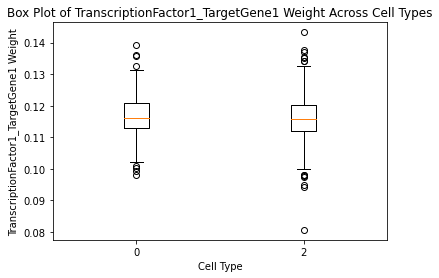

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

# 选择标签为0、2和11的数据
selected_labels = [0, 2, 11]
selected_data = tfm[tfm['y'].isin(selected_labels)]
# 分组数据框，按照 'y' 列的值进行分组
grouped = selected_data.groupby('y')
# 提取第一个转录因子对第一个靶基因的
data_to_plot = [group[1].values for name, group in grouped]

# 绘制箱线图
plt.boxplot(data_to_plot, labels=grouped.groups.keys())
plt.xlabel('Cell Type')
plt.ylabel('TranscriptionFactor1_TargetGene1 Weight')
plt.title('Box Plot of TranscriptionFactor1_TargetGene1 Weight Across Cell Types')
plt.show()



KeyError: 174930

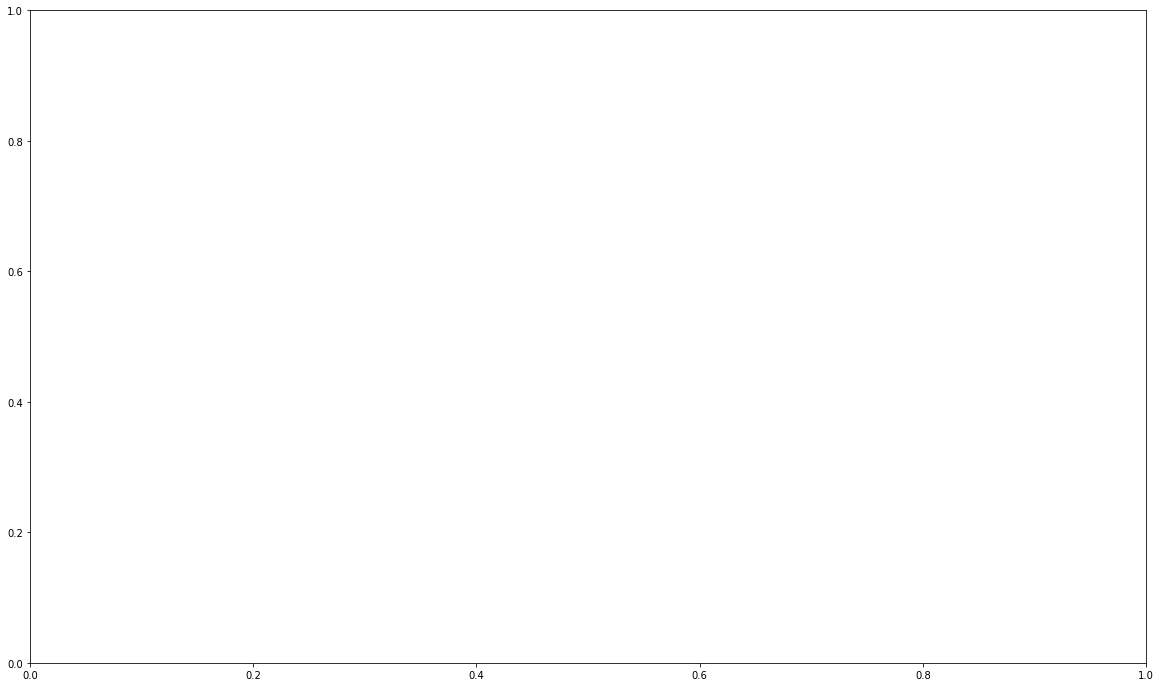

In [34]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load your data
tfname = pd.read_csv("{}/{}".format(input_path, "tf_gene.csv"), index_col=0)
tfm = pd.DataFrame(tf)
tfm.index = barcodes
tfm['y'] = actuals

# Define y column as Categorical data type with specified order
tfm['y'] = pd.Categorical(tfm['y'], categories=[0, 2, 11], ordered=True)

# Select labels 0, 2, and 11
selected_labels = [0, 2, 11]
selected_data = tfm[tfm['y'].isin(selected_labels)]

# Group the data by 'y' column
grouped = selected_data.groupby('y')

# Create a figure and axis using Seaborn
fig, ax = plt.subplots(figsize=(20, 12))

# Store all box plot data
all_data_to_plot = []

# Loop through each transcription factor and add data to all_data_to_plot
data_to_plot = [group[34594].values for name, group in grouped]#ANXA4
all_data_to_plot.extend(data_to_plot)  # 将数据添加到 all_data_to_plot 中

data_to_plot = [group[174930].values for name, group in grouped]#SPI1
all_data_to_plot.extend(data_to_plot)  # 将数据添加到 all_data_to_plot 中

data_to_plot = [group[71540].values for name, group in grouped]#SLIT2
all_data_to_plot.extend(data_to_plot)  # 将数据添加到 all_data_to_plot 中

data_to_plot = [group[64876].values for name, group in grouped]#GPR87
all_data_to_plot.extend(data_to_plot)  # 将数据添加到 all_data_to_plot 中

data_to_plot = [group[181888].values for name, group in grouped]#DYNC2H1
all_data_to_plot.extend(data_to_plot)  # 将数据添加到 all_data_to_plot 中

data_to_plot = [group[162876].values for name, group in grouped]#UBE2D1
all_data_to_plot.extend(data_to_plot)  # 将数据添加到 all_data_to_plot 中

data_to_plot = [group[7938].values for name, group in grouped]#L1TD1
all_data_to_plot.extend(data_to_plot)  # 将数据添加到 all_data_to_plot 中
data_to_plot = [group[142100].values for name, group in grouped]#PKIA
all_data_to_plot.extend(data_to_plot)  # 将数据添加到 all_data_to_plot 中
data_to_plot = [group[216286].values for name, group in grouped]#PLEKHD1
all_data_to_plot.extend(data_to_plot)  # 将数据添加到 all_data_to_plot 中
data_to_plot = [group[32340].values for name, group in grouped]#C2ORF91
all_data_to_plot.extend(data_to_plot)  # 将数据添加到 all_data_to_plot 中
a=pd.DataFrame(['E2F2_ANXA4','E2F2_ANXA4','E2F2_ANXA4',
                'E2F2_SPI1','E2F2_SPI1','E2F2_SPI1',
                'E2F2_SLIT2','E2F2_SLIT2','E2F2_SLIT2',
    "E2F2_GPR87", "E2F2_GPR87", "E2F2_GPR87",
    "E2F2_DYNC2H1", "E2F2_DYNC2H1", "E2F2_DYNC2H1",
    "E2F2_UBE2D1", "E2F2_UBE2D1", "E2F2_UBE2D1",
    "E2F2_L1TD1", "E2F2_L1TD1", "E2F2_L1TD1",
    "E2F2_PKIA", "E2F2_PKIA", "E2F2_PKIA",
    "E2F2_PLEKHD1", "E2F2_PLEKHD1", "E2F2_PLEKHD1",
    "E2F2_C2ORF91", "E2F2_C2ORF91", "E2F2_C2ORF91"
])


palette = sns.color_palette("Set3", n_colors=3)  # You can choose any palette you like

# Set the dodge width to 0 for no separation between boxes
sns.boxplot(data=all_data_to_plot, ax=ax, orient='v', palette=palette, dodge=True)

# # # Create large gaps between every three boxes

# for i in range(2, len(all_data_to_plot), 3):
#     ax.vlines(x=i + 0.5, colors='gray', linestyles='dashed', linewidth=2)


# # Create a box plot using Seaborn
# sns.boxplot(data=all_data_to_plot, ax=ax,orient='v')

# Set labels and title
ax.set_xlabel('Cell Type')
ax.set_ylabel('Transcription Factor Weight')
ax.set_title('Box Plots of Transcription Factor Weights Across Cell Types')

# 保存图形为PDF文件
plt.savefig("transcription_factor_weights.pdf", format="pdf")

# 显示图形
plt.show()


In [ ]:
grouped.groups.keys

<function PrettyDict.keys>

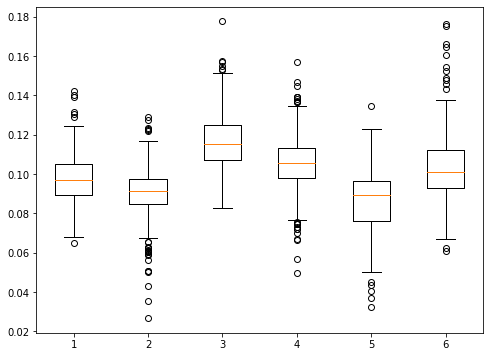

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 选择标签为0、2和11的数据
selected_labels = [0, 2, 11]
selected_data = tfm[tfm['y'].isin(selected_labels)]
# 分组数据框，按照 'y' 列的值进行分组
grouped = selected_data.groupby('y')

# 创建一个图形对象，包含一个坐标轴
fig, ax = plt.subplots(figsize=(8, 6))

# 存储所有箱线图数据
all_data_to_plot = []

# 循环处理每个转录因子
data_to_plot = [group[353].values for name, group in grouped]#AX
all_data_to_plot.extend(data_to_plot)  # 将数据添加到 all_data_to_plot 中

data_to_plot = [group[1785].values for name, group in grouped]#AX
all_data_to_plot.extend(data_to_plot)  # 将数据添加到 all_data_to_plot 中

data_to_plot = [group[2232].values for name, group in grouped]#SPATA7
all_data_to_plot.extend(data_to_plot)  # 将数据添加到 all_data_to_plot 中

# 绘制多个箱线图，每个箱线图位于不同的位置
positions = range(1, len(all_data_to_plot) + 1)
ax.boxplot(all_data_to_plot, labels=range(1, len(all_data_to_plot) + 1), positions=positions)

# # 设置坐标轴标签和标题
# ax.set_xlabel('Cell Type')
# ax.set_ylabel('Transcription Factor Weight')
# ax.set_title('Box Plots of Transcription Factor Weights Across Cell Types')

# 显示图形
plt.show()


In [ ]:
from scipy import stats
# 执行Wilcoxon秩和检验并计算p值
p_values = []
for i in range(len(data_to_plot)):
    for j in range(i+1, len(data_to_plot)):
        statistic, p_value = stats.ranksums(data_to_plot[i], data_to_plot[j])
        p_values.append(p_value)

# 输出多个Wilcoxon秩和检验的p值
print('Wilcoxon Rank-Sum Test p-values:')
for i, p_value in enumerate(p_values):
    print(f'Comparison {i+1}: {p_value}')

Wilcoxon Rank-Sum Test p-values:
Comparison 1: 3.1141587842965904e-200
Comparison 2: 1.0379975804004612e-64
Comparison 3: 3.284577663865224e-25


In [ ]:
from statsmodels.stats.multitest import multipletests
import statsmodels.api as sm
# 使用 Holm 方法进行多重比较校正
reject, corrected_p_values, _, _ = sm.stats.multipletests(p_values, method='holm')

# 输出校正后的p值
print('Corrected p-values using Holm method:')
for i, p_value in enumerate(corrected_p_values):
    print(f'Comparison {i+1}: {p_value}')

Corrected p-values using Holm method:
Comparison 1: 9.342476352889771e-200
Comparison 2: 2.0759951608009224e-64
Comparison 3: 3.284577663865224e-25
